In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 200
pd.set_option('display.max_columns', 5000)
from tqdm import tqdm
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from tensorflow import keras
from keras import regularizers
from keras.metrics import MeanAbsoluteError
from keras import layers as l
from keras.models import Sequential
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.pipeline import Pipeline
#!pip install category_encoders
from sklearn.model_selection import  train_test_split
from sklearn import model_selection
from category_encoders import GLMMEncoder

In [2]:
extra_diagnoses = pd.read_csv("extra_diagnoses.csv")

data = pd.read_csv("train_los.csv")
test = pd.read_csv("test_los.csv")
submission_csv = pd.read_csv("sample_sol_los.csv")

submission_csv = pd.read_csv("sample_sol_los.csv")

test_id = pd.read_csv("test_los.csv")

In [3]:
extra_diagnoses.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [4]:
extra = extra_diagnoses.copy()
unique = data["subject_id"].unique()
unique

array([55440, 28424, 86233, ...,  9725, 22337, 94290], dtype=int64)

In [6]:
dicto = {}
for n in tqdm(unique):
    dicto.update({n: len(extra.query("SUBJECT_ID == {}".format(n))["HADM_ID"].unique())})


100%|██████████| 10959/10959 [01:05<00:00, 166.33it/s]


In [7]:
unique = data["hadm_id"].unique()
dicto2 = {}
for n in tqdm(unique):
    dicto2.update({n: len(extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique())})
    

100%|██████████| 13025/13025 [01:16<00:00, 171.28it/s]


In [8]:
dicto3 = {}
for n in tqdm(unique):
    dicto3.update({n: extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique()})


100%|██████████| 13025/13025 [01:16<00:00, 170.89it/s]


In [9]:
data["num_stays"] = data["subject_id"].map(dicto)
data["num_dis"] = data["hadm_id"].map(dicto2)
data["dis"] = data["hadm_id"].map(dicto3)

In [10]:
data["dis"].head(10)

0    [5789, 51881, 41071, 42831, 42732, 2851, 53550...
1    [56211, 5185, 9973, 5180, 9341, 99859, 6822, 9...
2    [1625, 5185, 486, 5180, 9341, 5119, 5990, 2762...
3    [49322, 5849, 27651, 4659, 40390, 5859, 25002,...
4    [41511, 42831, 5119, 5121, 1628, 1985, 29632, ...
5    [4241, 99812, 41401, 4139, 4019, 2724, 25000, ...
6    [41011, 5845, 42821, 7907, 4280, 5853, 42731, ...
7    [3941, 3940, 5849, 5990, 2851, 5119, 4239, 427...
8    [85206, 2930, 8024, 8026, 8028, 87349, 29690, ...
9    [41401, 42823, 4271, 45829, 2875, 4254, 25000,...
Name: dis, dtype: object

In [11]:
unique = test["subject_id"].unique()
dicto = {}
for n in tqdm(unique):
    dicto.update({n: len(extra.query("SUBJECT_ID == {}".format(n))["HADM_ID"].unique())})
unique = test["hadm_id"].unique()
dicto2 = {}
for n in tqdm(unique):
    dicto2.update({n: len(extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique())})
dicto3 = {}
for n in tqdm(unique):
    dicto3.update({n: extra.query("HADM_ID == {}".format(n))["ICD9_CODE"].unique()})


100%|██████████| 11217/11217 [01:16<00:00, 147.50it/s]


In [12]:
test["num_stays"] = test["subject_id"].map(dicto)
test["num_dis"] = test["hadm_id"].map(dicto2)
test["dis"] = test["hadm_id"].map(dicto3)

In [ ]:
DO NOT RUN THIS PART

In [ ]:
"""test["nthstay"] = test["hadm_id"]*np.nan
test["remove"] = test["hadm_id"]*0

test["nthstay"] = test["hadm_id"]
data["remove"] = data["hadm_id"]

stacked = pd.concat([test,data], axis = 0)
stacked["ADMITTIME"] = pd.to_datetime(stacked["ADMITTIME"])
stacked.sort_values(by ="ADMITTIME",ascending = True, inplace = True)


dicto = {}
for n in tqdm(range(len(stacked))):
    temp = stacked["subject_id"].iloc[n]
    keys = dicto.keys()
    if temp in keys:
        v = dicto[temp] + 1
        dicto[temp] = v
        stacked["nthstay"].iloc[n] = v
    else:
        dicto[temp] = 1
        stacked["nthstay"].iloc[n] = 1
    

stacked.query("remove ==0")["HOSPITAL_EXPIRE_FLAG"].sum()

stacked.query("remove != 0")["HOSPITAL_EXPIRE_FLAG"].sum()

data["HOSPITAL_EXPIRE_FLAG"].sum()

test_split = stacked.query("remove == 0")
train_split = stacked.query("remove != 0")
#test_split.drop("HOSPITAL_EXPIRE_FLAG", inplace = True, axis = 1)
#test_split.drop("remove", inplace = True, axis = 1)
#train_split.drop("remove", inplace = True, axis = 1)


test_split.query("remove != 0")["HOSPITAL_EXPIRE_FLAG"].sum()

train_split.query("remove != 0")["HOSPITAL_EXPIRE_FLAG"].sum()

init_sorted = init.sort_values(by ="hadm_id",ascending = True)
train_split.sort_values(by ="hadm_id",ascending = True, inplace = True)
init_test_sorted = init_test.sort_values(by ="hadm_id",ascending = True)
test_split.sort_values(by ="hadm_id",ascending = True, inplace = True)
test_test = test_split.copy()
data_test = train_split.copy()
sum(data_test["HOSPITAL_EXPIRE_FLAG"].values == init["HOSPITAL_EXPIRE_FLAG"].values)
sum(test_test["DOB"].values == init_test["DOB"].values)
test = test_split.copy()
data = train_split.copy()
sum(data["HOSPITAL_EXPIRE_FLAG"].values == init["HOSPITAL_EXPIRE_FLAG"])
sum(test["DOB"].values == init_test["DOB"].values)"""

In [13]:
test["AGE"] = (pd.to_datetime(test["ADMITTIME"])- pd.to_datetime(test["DOB"])).dt.total_seconds()//3.154e+7
data["AGE"] = (pd.to_datetime(data["ADMITTIME"])- pd.to_datetime(data["DOB"])).dt.total_seconds()//3.154e+7


In [14]:
data["NAN"] = (1*data.isna()).sum(axis = 1)
test["NAN"] = (1*test.isna()).sum(axis = 1) 

In [15]:
data["MARITAL_STATUS"] = data["MARITAL_STATUS"] .replace(np.nan, 'UNKNOWN (DEFAULT)', regex=True)
test["MARITAL_STATUS"] = test["MARITAL_STATUS"] .replace(np.nan, 'UNKNOWN (DEFAULT)', regex=True)

In [16]:
train = data.copy()

In [17]:
train["GENDER"] = [1 if x == "M" else 0 for x in train["GENDER"]]
test["GENDER"] = [1 if x == "M" else 0 for x in test["GENDER"]]
train.drop("DOB", axis = 1, inplace = True)
test.drop("DOB", axis = 1, inplace = True)
train.drop("LOS", axis = 1, inplace = True)

In [18]:
numerical = []
for n in train.columns:
  if train[n].dtype == "int64" or train[n].dtype =="float64":
    numerical.append(n)

cat = list(set(train.columns) - set(train[numerical].columns))
y = data["LOS"]
X = train.copy()

In [19]:
from category_encoders import TargetEncoder

In [20]:
enc = TargetEncoder()
at_train = train.copy()
at_test = test.copy()
at_train["ICD9_diagnosisT"] = enc.fit_transform(at_train["ICD9_diagnosis"], y)
at_test["ICD9_diagnosisT"] = enc.transform(at_test["ICD9_diagnosis"])

In [21]:
at_train[["ICD9_diagnosisT", "ICD9_diagnosis"]]

,ICD9_diagnosisT,ICD9_diagnosis
0,2.420315,5789
1,3.982390,56211
2,2.836679,1625
3,2.715168,49322
4,2.293586,41511
...,...,...
13835,2.042906,5990
13836,2.136175,56212
13837,2.420315,5789
13838,3.267321,41071


In [22]:
mix_train = at_train[["ICD9_diagnosisT", "ICD9_diagnosis"]]
mix_test = at_test[["ICD9_diagnosisT", "ICD9_diagnosis"]]

In [23]:
mix_train["ICD9_diagnosis"]

0         5789
1        56211
2         1625
3        49322
4        41511
         ...  
13835     5990
13836    56212
13837     5789
13838    41071
13839    56881
Name: ICD9_diagnosis, Length: 13840, dtype: object

In [24]:
mix_train.index = mix_train["ICD9_diagnosis"]
mix_train.drop(["ICD9_diagnosis"], axis = 1, inplace = True)


In [25]:
mix_train

,ICD9_diagnosisT
ICD9_diagnosis,
5789,2.420315
56211,3.982390
1625,2.836679
49322,2.715168
41511,2.293586
...,...
5990,2.042906
56212,2.136175
5789,2.420315


In [26]:
dicto = mix_train.to_dict()

In [27]:
dicto

{'ICD9_diagnosisT': {'5789': 2.4203148437499995,
  '56211': 3.982389999999835,
  '1625': 2.8366791667173388,
  '49322': 2.7151677419355407,
  '41511': 2.2935864631510148,
  '4241': 3.1841856382978753,
  '41011': 3.1951321428571435,
  '3941': 4.961054789221165,
  '85206': 4.290143477993172,
  '41401': 2.252512666666665,
  '1508': 3.730568181514804,
  '5070': 3.429415168539326,
  '5849': 2.0132770700636944,
  '1911': 2.054657692325411,
  '53140': 2.0368615384615385,
  '5307': 2.449496666666891,
  '64881': 3.3304695303468463,
  '03849': 5.02741320754717,
  '86405': 3.7324596657336566,
  '2910': 2.562146666666862,
  '4373': 1.4704586666666661,
  '64891': 2.442535473716209,
  '9982': 4.622711538443592,
  '4260': 3.0741807692343284,
  '5771': 2.2195188600682694,
  '85201': 2.3933833721281177,
  '1913': 1.2905289767942143,
  '53120': 3.3304695303468463,
  '99666': 4.386899983910585,
  '9654': 2.848202127659575,
  '5848': 3.3304695303468463,
  '7863': 2.891701881977731,
  '53440': 1.7917284435

In [28]:
true_dicto = dicto["ICD9_diagnosisT"]
none_dicto = {None : np.nan}
for n in tqdm(range(len(train))):
    l = list(train["dis"].iloc[n])
    v = list(map(true_dicto.get, l))
    v2 = [x for x in v if x != None]
    if len(v2) == 0:
        v2 = [0]
    v = [x if x != None else np.mean(v2) for x in v]
    v = np.sum(v)
    train["dis"].iloc[n] = v
    
for n in tqdm(range(len(test))):
    l = list(test["dis"].iloc[n])
    v = list(map(true_dicto.get, l))
    v2 =  [x for x in v if x != None]
    if len(v2) == 0:
        v2 = [0]
    v = [x if x != None else np.mean(v2) for x in v]
    v = np.sum(v) 
    test["dis"].iloc[n] = v

100%|██████████| 12065/12065 [00:05<00:00, 2229.96it/s]


In [29]:
train["dis"]

0        49.6719
1        61.0601
2        56.4892
3        24.3314
4        60.6261
          ...   
13835    18.0064
13836    53.1966
13837    23.5313
13838    34.1829
13839    36.7829
Name: dis, Length: 13840, dtype: object

In [30]:
test["dis"]

0        2.87265
1        46.9352
2        56.7406
3         19.071
4        47.1692
          ...   
12060    147.661
12061    91.9835
12062    37.5399
12063     33.496
12064     40.337
Name: dis, Length: 12065, dtype: object

In [31]:
y = data["LOS"]
train = pd.concat([y,train], axis=1)

In [32]:
#train.to_csv("final_version_train.csv", index = False)
#test.to_csv("final_version_test.csv", index = False)

CHECKPOINT

In [82]:
train = pd.read_csv("final_version_train.csv")
test = pd.read_csv("final_version_test.csv")


In [83]:

train["NAN"] = [1 if x >= 20 else 0  for x in train["NAN"]]
test["NAN"] = [1 if x >=20 else 0  for x in test["NAN"]]


In [84]:
train = train.query("NAN == 0")

In [85]:
y = train["LOS"]
train.drop("LOS", axis = 1,inplace = True)

In [86]:
train.drop(["subject_id", "hadm_id", "icustay_id", "ADMITTIME","NAN"],axis =1, inplace= True)
test.drop(["subject_id", "hadm_id", "icustay_id", "ADMITTIME","NAN"],axis =1, inplace= True)
test.drop(["Glucose_Min", "Glucose_Max", "Glucose_Mean"], axis = 1, inplace = True)
train.drop(["Glucose_Min", "Glucose_Max", "Glucose_Mean"], axis = 1, inplace = True)

In [87]:
ZZZ = train.copy()

In [88]:
hasnan2 = []        
for n in test.columns:
    if test[n].isnull().values.any() == True:
        hasnan2.append(n)

In [89]:
test[hasnan2] = test[hasnan2].apply(lambda x: x.fillna(x.mean()),axis=0)

In [90]:
cat = list(set(cat) - set(["ADMITTIME"]))
cat

['FIRST_CAREUNIT',
 'DIAGNOSIS',
 'MARITAL_STATUS',
 'ADMISSION_TYPE',
 'ICD9_diagnosis',
 'INSURANCE',
 'RELIGION',
 'ETHNICITY']

In [91]:
"""enc = TargetEncoder()
ZZZ[cat] = enc.fit_transform(train[cat], y) 
test[cat] = enc.transform(test[cat]) 
sc = StandardScaler()
ZZZ = sc.fit_transform(ZZZ) 
test = sc.transform(test)""" 

'enc = TargetEncoder()\nZZZ[cat] = enc.fit_transform(train[cat], y) \ntest[cat] = enc.transform(test[cat]) \nsc = StandardScaler()\nZZZ = sc.fit_transform(ZZZ) \ntest = sc.transform(test)'

In [92]:

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state = 324)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 424)


In [93]:
cat = ["ICD9_diagnosis", "DIAGNOSIS", "ADMISSION_TYPE", "INSURANCE","MARITAL_STATUS","FIRST_CAREUNIT", "RELIGION", "ETHNICITY"]

In [94]:
train.describe()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,GENDER,num_stays,num_dis,dis,AGE
count,11177.000000,11177.000000,11177.000000,11164.000000,11164.000000,11164.000000,11164.000000,11164.000000,11164.000000,11177.000000,11177.000000,11177.000000,11175.000000,11175.000000,11175.000000,10995.000000,10995.000000,10995.000000,11167.000000,11167.000000,11167.000000,11181.000000,11181.000000,11181.000000,11181.000000,11181.000000
mean,69.750201,105.114414,85.164834,91.508241,150.709423,119.269259,44.504568,88.411233,62.671524,56.529122,107.142077,77.746325,11.928814,27.701566,18.957917,36.043670,37.431920,36.750059,90.961673,99.536581,96.834870,0.559431,2.120025,14.716662,44.839542,63.727842
std,14.864204,20.775290,15.305729,17.818725,23.995762,16.949842,11.947235,19.604837,11.141381,14.477671,28.074985,11.274795,3.596712,6.301986,3.852683,0.737252,0.802030,0.602798,7.546486,1.356379,2.430978,0.496478,2.977208,7.137209,24.724406,17.333885
min,2.000000,39.000000,34.714286,10.000000,70.000000,50.863636,5.000000,35.000000,28.181818,1.000000,44.000000,25.759907,1.000000,12.000000,9.371429,22.777778,31.600000,31.600000,1.000000,42.000000,42.000000,0.000000,1.000000,1.000000,0.591908,15.000000
25%,60.000000,90.000000,74.375000,81.000000,134.000000,107.101780,37.000000,75.000000,55.090241,49.000000,91.000000,70.071429,10.000000,23.000000,16.216804,35.666667,36.944444,36.388889,90.000000,100.000000,95.784749,0.000000,1.000000,9.000000,26.284294,53.000000
50%,69.000000,103.000000,84.117647,91.000000,148.000000,116.908135,44.000000,86.000000,61.574603,57.000000,102.000000,76.363636,12.000000,27.000000,18.333333,36.111111,37.333333,36.734568,92.000000,100.000000,97.125000,1.000000,1.000000,14.000000,41.090107,65.000000
75%,79.000000,117.000000,95.240000,102.000000,165.000000,129.524638,52.000000,98.000000,69.171527,65.000000,115.000000,84.400000,14.000000,31.000000,21.050000,36.500000,37.888889,37.092593,94.000000,100.000000,98.343750,1.000000,2.000000,19.000000,58.798681,77.000000
max,143.000000,222.000000,163.875000,181.000000,311.000000,201.088235,105.000000,294.000000,116.140000,122.000000,299.000000,135.000000,31.000000,69.000000,41.235294,40.000000,42.000000,40.000000,100.000000,100.000000,100.000000,1.000000,42.000000,39.000000,160.816517,99.000000


In [95]:
sc = StandardScaler()
enc = TargetEncoder()
X_train[cat] = enc.fit_transform(X_train[cat], y_train) 
X_test[cat] = enc.transform(X_test[cat])
X_dev[cat] = enc.transform(X_dev[cat])
test[cat] = enc.transform(test[cat])

hasnan = []
for n in X_train.columns:
    if X_train[n].isnull().values.any() == True:
        hasnan.append(n)
hasnan3 = []        
for n in X_test.columns:
    if X_test[n].isnull().values.any() == True:
        hasnan3.append(n)
hasnan4 = []        
for n in X_dev.columns:
    if X_dev[n].isnull().values.any() == True:
        hasnan4.append(n)
                
        
X_train[hasnan] = X_train[hasnan].apply(lambda x: x.fillna(x.mean()),axis=0)

X_test[hasnan3] = X_test[hasnan3].apply(lambda x: x.fillna(x.mean()),axis=0)
X_dev[hasnan4] = X_dev[hasnan4].apply(lambda x: x.fillna(x.mean()),axis=0)


In [96]:
X_train =sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_dev = sc.transform(X_dev)
test = sc.transform(test) 


In [97]:
import kerastuner as kt
from keras import layers as l
N_INPUTS = X_test.shape[1]

class MyTuner(kt.tuners.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size',values=[32, 64, 128, 256],default=64)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [148]:
def reg(hp):
    
    model = Sequential()
    act = hp.Choice('dense_activation',values=['relu', 'selu','elu'],default='selu')
    hp_reg2 = hp.Float('regularizers_2', min_value=0.00000001, max_value=1, default=0.01,sampling='LOG') 
    #hp_reg2 = None
    hp_reg1 = None #turns out that suggesting sparsity is a very bad idea
    drop = hp.Float('dropout',min_value=0.0,max_value=0.5,default=0.25,step=0.05)
    
    units_0 = hp.Choice('units_0',values=[32,64, 96, 128, 160, 192],default=96)
    units_1 = hp.Choice('units_1',values=[32,64, 96, 128],default=64)
    units_2 = hp.Choice('units_2',values=[32, 48, 64, 96],default=64)
    
    model.add(l.Dense(units = units_0, use_bias=True,  input_dim=N_INPUTS, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dense(units = units_0,
                      use_bias=True,  activation=act,
                      kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_1, 
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    
    model.add(l.Dropout(rate = drop))
    model.add(l.Dense(units = units_2,
                      use_bias=True, activation=act,
                       kernel_regularizer=regularizers.l1_l2(l1 = hp_reg1, l2=hp_reg2)))
    
    
    model.add(l.Dense(1, activation ="linear"))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4,max_value=1e-2,default=1e-3, sampling='LOG')),
                  loss=hp.Choice('loss',values=['mse', 'mae'],default='mae'),metrics=['mae'])
    return model


In [161]:
tuner = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=6, seed = 2137, max_epochs = 15,  project_name = 'N')
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_dev, y_dev))

Trial 78 Complete [00h 00m 14s]
val_mae: 1.94671630859375

Best val_mae So Far: 1.796758770942688
Total elapsed time: 00h 08m 14s
INFO:tensorflow:Oracle triggered exit


In [162]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(X_test, y_test)

best_model.summary()
tuner.results_summary()

53/53 [==============================] - 1s 3ms/step - loss: 1.9227 - mae: 1.9126
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4480      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)                12384     
________________________________________

In [169]:
m = tuner.get_best_models(num_models=10)
i = 0
for n in m:
    n.evaluate(X_test, y_test)
    #filename = 'models/model_' + str('N{}'.format(i)) + '.h5'
    #n.save(filename)
    #i += 1

53/53 [==============================] - 0s 3ms/step - loss: 2.1385 - mae: 1.9393


In [164]:
y_trainL = np.log(y_train)
y_devL = np.log(y_dev)
y_testnL = np.log(y_test)

In [165]:
tunerL = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=6, seed = 2137, max_epochs = 15,  project_name = 'L')
tunerL.search(X_train, y_trainL, epochs = 10, validation_data = (X_dev, y_devL))

Trial 78 Complete [00h 00m 12s]
val_mae: 0.5363808274269104

Best val_mae So Far: 0.5322744846343994
Total elapsed time: 00h 08m 14s
INFO:tensorflow:Oracle triggered exit


In [166]:
best_modelL = tunerL.get_best_models(num_models=1)[0]
best_modelL.evaluate(X_test, y_testnL)

best_modelL.summary()
tunerL.results_summary()

53/53 [==============================] - 0s 3ms/step - loss: 0.4961 - mae: 0.5496
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160)               5600      
_________________________________________________________________
dense_1 (Dense)              (None, 160)               25760     
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                15456     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                6208      
________________________________________

In [168]:
from sklearn.metrics import mean_absolute_error
m = tunerL.get_best_models(num_models=10)
i =0
for n in m:
    print(mean_absolute_error(y_test, np.exp(n.predict(X_test))))
    #filename = 'models/model_' + str('L{}'.format(i)) + '.h5'
    #n.save(filename)
    #i += 1

1.7861103264108178
1.8139287980861118
1.829419306692307
1.8115675908712152
1.7948940929641313
1.7964080703499776
1.8229665946762525
1.8141144715424233
1.8075103749399246
1.8218228737790692


1.7886856226960606


(0.0, 5.0)

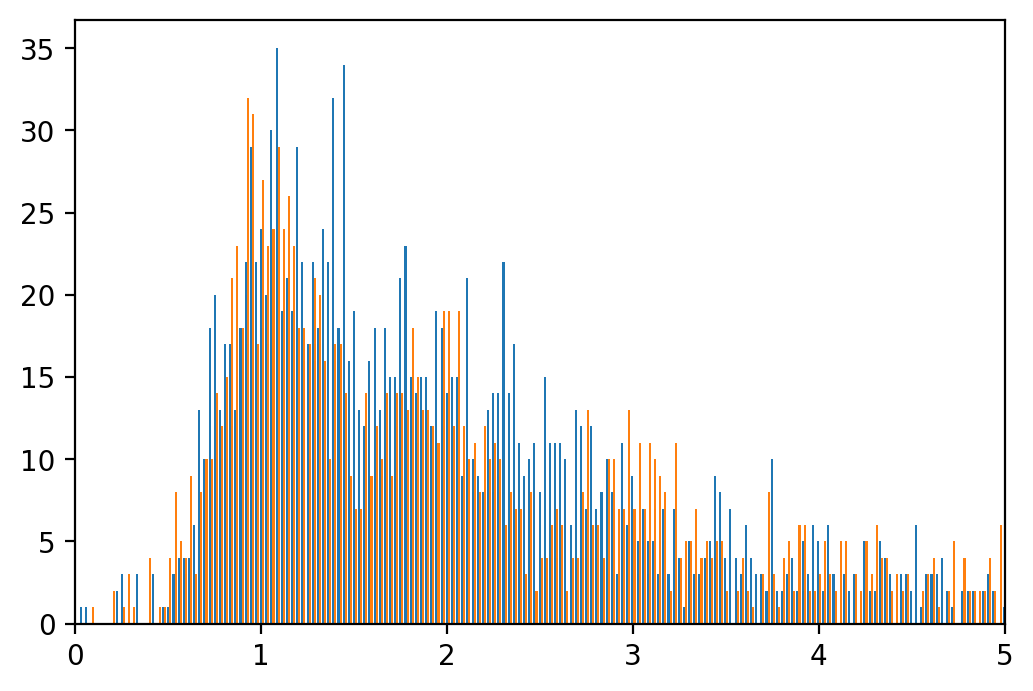

In [257]:
predN = best_model.predict(X_dev)
predL = np.exp(best_modelL.predict(X_dev))
preDb = (predN+predL)/2 - 0.3
preD = np.array([x if x <1.5 else y-0.3  for x,y in zip(preDb, predL)])

print(mean_absolute_error(y_dev,preD))
_=plt.hist([preD.flatten(),y_dev], bins = 1000)
plt.xlim(0,5)


#something like this give 1.96 on the kaggle test set

1.8307447462929303


(0.0, 5.0)

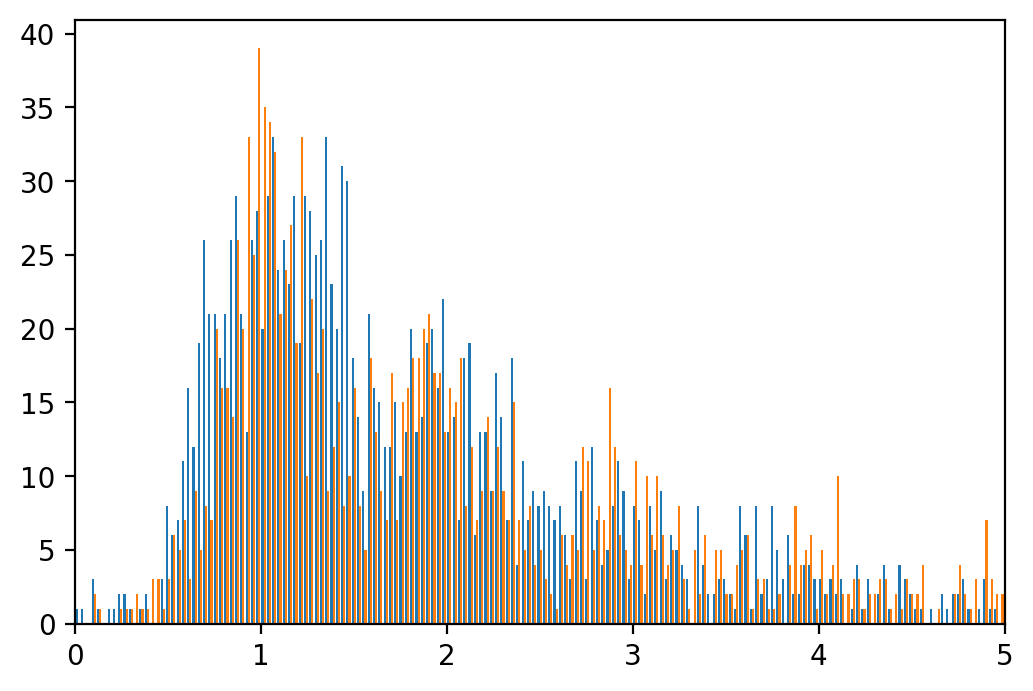

In [253]:
predN = best_model.predict(X_test)
predL = np.exp(best_modelL.predict(X_test))
preDb = (predN+predL)/2 - 0.4
preD = np.array([x if x <1.5 else y-0.4  for x,y in zip(preDb, predL)])

print(mean_absolute_error(y_test,preD))
_=plt.hist([preD.flatten(),y_test], bins = 1000)
plt.xlim(0,5)

(0.0, 5.0)

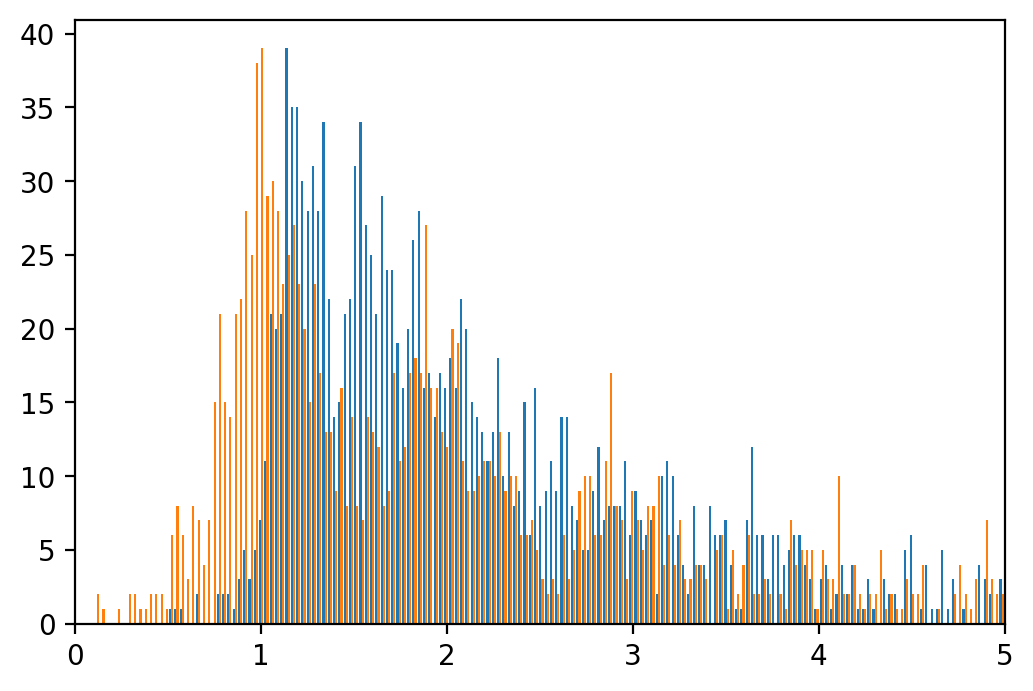

In [182]:
_=plt.hist([predN.flatten(),y_test], bins = 1000)
plt.xlim(0,5)

(0.0, 5.0)

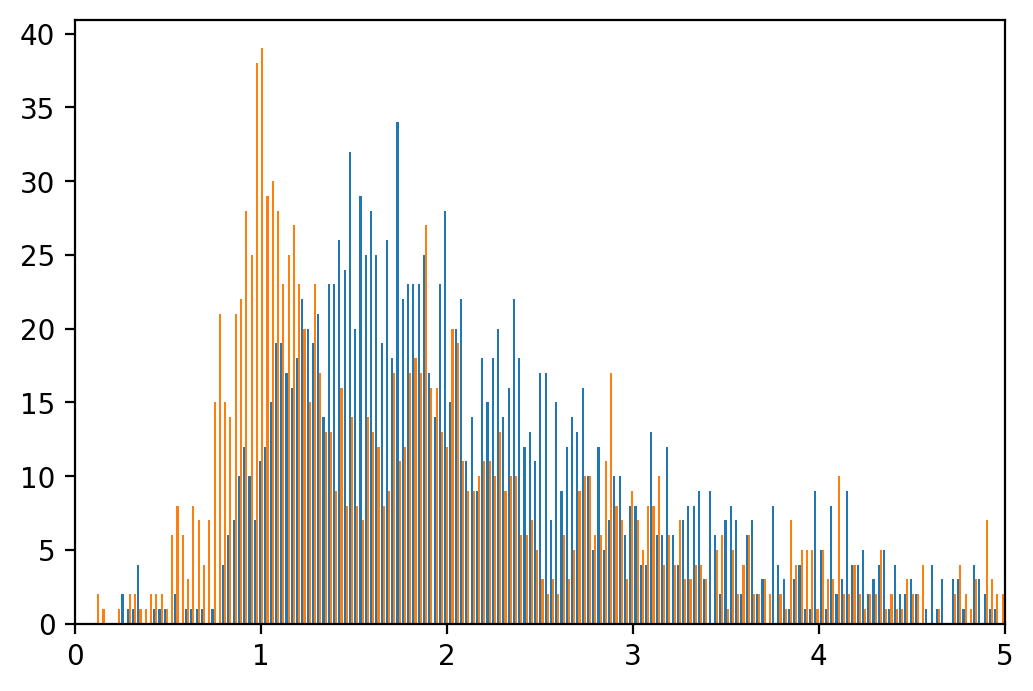

In [183]:
_=plt.hist([predL.flatten(),y_test], bins = 1000)
plt.xlim(0,5)

(0.0, 5.0)

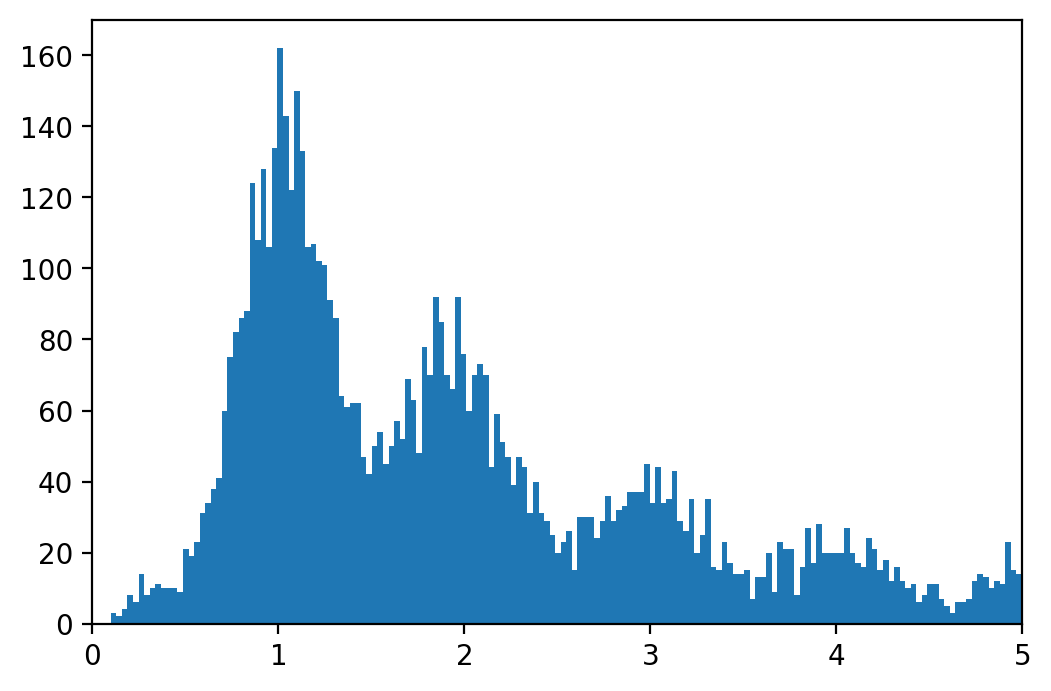

In [176]:
_=plt.hist(y_train, bins = 1000)
plt.xlim(0,5)

In [184]:
input_data = keras.Input(shape=(N_INPUTS,))
encoded = l.Dense(N_INPUTS, activation='relu', activity_regularizer=keras.regularizers.l1_l2(None, None))(input_data)

encoded = l.Dense(25)(encoded)

decoded = l.Dense(N_INPUTS, activation='linear')(encoded)

autoencoder = keras.Model(input_data, decoded)
autoencoder.summary()
autoencoder.compile(optimizer="adam", loss='mse')
autoencoder.fit(X_train, X_train,
                epochs=35,
                batch_size=64,
                verbose = 2,
                validation_data=(X_dev, X_dev))



encoder = keras.Model(inputs=input_data, outputs=encoded)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 34)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 34)                1190      
_________________________________________________________________
dense_6 (Dense)              (None, 25)                875       
_________________________________________________________________
dense_7 (Dense)              (None, 34)                884       
Total params: 2,949
Trainable params: 2,949
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
123/123 - 1s - loss: 0.8708 - val_loss: 0.5711
Epoch 2/35
123/123 - 1s - loss: 0.4981 - val_loss: 0.3989
Epoch 3/35
123/123 - 0s - loss: 0.3597 - val_loss: 0.3011
Epoch 4/35
123/123 - 0s - loss: 0.2755 - val_loss: 0.2372
Epoch 5/35
123/123 - 0s -

In [185]:
Z = pd.DataFrame(encoder.predict(X_train))
Zd = pd.DataFrame(encoder.predict(X_dev))
Zt = pd.DataFrame(encoder.predict(X_test))
TT = pd.DataFrame(encoder.predict(test))
print(Z.shape,Zd.shape, Zt.shape,  TT.shape)

(7826, 25) (1677, 25) (1678, 25) (12065, 25)


In [186]:
N_INPUTS = Zt.shape[1]
tunerZ = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=6, seed = 2137, max_epochs = 15,  project_name = 'Z')
tunerZ.search(Z, y_train, epochs = 10, validation_data = (Zd, y_dev))

Trial 78 Complete [00h 00m 12s]
val_mae: 1.9700051546096802

Best val_mae So Far: 1.7987545728683472
Total elapsed time: 00h 07m 52s
INFO:tensorflow:Oracle triggered exit


In [187]:
best_modelZ = tunerZ.get_best_models(num_models=1)[0]
best_modelZ.evaluate(Zt, y_test)

best_modelZ.summary()
tunerZ.results_summary()

53/53 [==============================] - 1s 4ms/step - loss: 1.9125 - mae: 1.9124
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3328      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 96)                3168      
________________________________________

In [189]:
m = tunerZ.get_best_models(num_models=10)
i = 0
for n in m:
    n.evaluate(Zt, y_test)
    filename = 'models/model_' + str('Z{}'.format(i)) + '.h5'
    n.save(filename)
    i += 1

53/53 [==============================] - 0s 2ms/step - loss: 2.3388 - mae: 1.9480


In [190]:
tunerZL = MyTuner(reg, objective = "val_mae", factor=5, hyperband_iterations=6, seed = 2137, max_epochs = 15,  project_name = 'ZL')
tunerZL.search(Z, y_trainL, epochs = 10, validation_data = (Zd, y_devL))

Trial 78 Complete [00h 00m 14s]
val_mae: 0.5404874086380005

Best val_mae So Far: 0.5361529588699341
Total elapsed time: 00h 07m 51s
INFO:tensorflow:Oracle triggered exit


In [191]:
best_modelZL = tunerZL.get_best_models(num_models=1)[0]
best_modelZL.evaluate(Zt, y_testnL)

best_modelZL.summary()
tunerZL.results_summary()

53/53 [==============================] - 0s 3ms/step - loss: 0.5619 - mae: 0.5577
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)                3120      
________________________________________

In [192]:
m = tunerZL.get_best_models(num_models=10)
i =0
for n in m:
    print(mean_absolute_error(y_test, np.exp(n.predict(Zt))))
    #filename = 'models/model_' + str('ZL{}'.format(i)) + '.h5'
    #n.save(filename)
    #i += 1

1.8336391017265767
1.856591054658611
1.8368065121048966
1.8537214569592504
1.8381828395082782
1.865208833994939
1.843889416800956
1.8409318124240357
1.853720288071999
1.8422199031738897


In [194]:
predZ = best_modelZ.predict(Zt)
predZL = np.exp(best_modelZL.predict(Zt))

(0.0, 5.0)

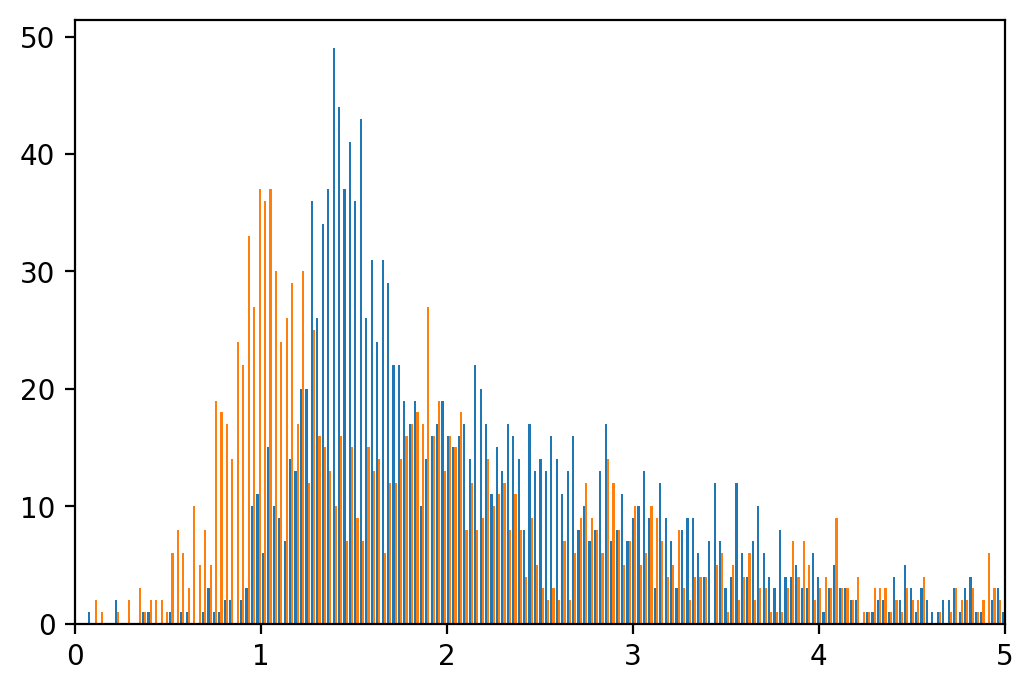

In [195]:
_=plt.hist([predZ.flatten(),y_test], bins = 1000)
plt.xlim(0,5)

(0.0, 5.0)

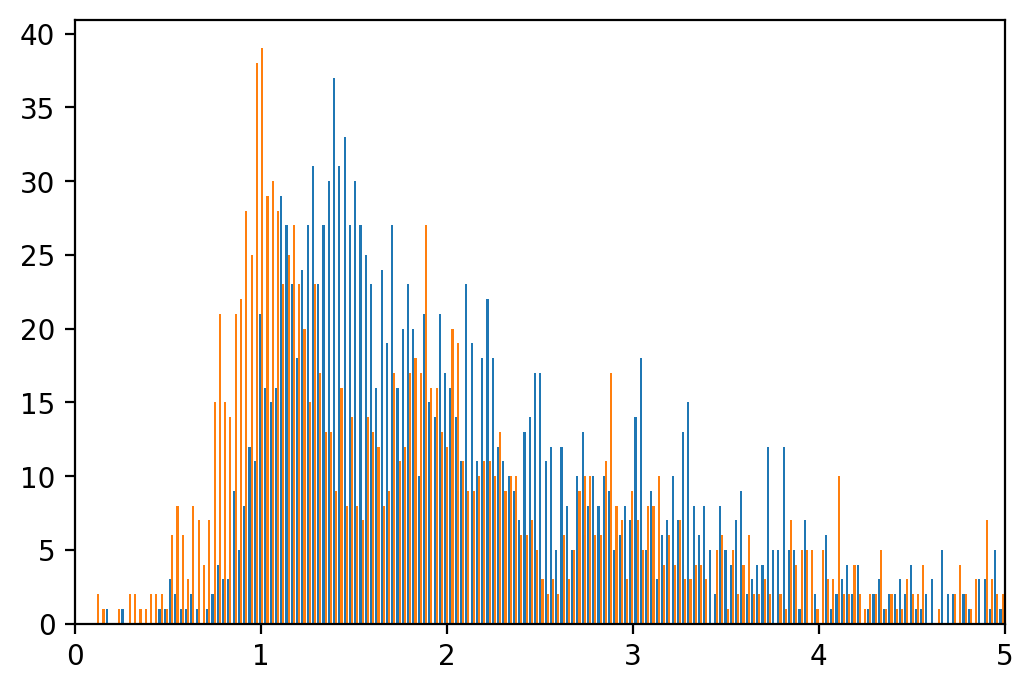

In [197]:
_=plt.hist([predZL.flatten(),y_test], bins = 1000)
plt.xlim(0,5)

RBF from https://github.com/PetraVidnerova/rbf_for_tf2

In [4]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MSE
from rbflayer import RBFLayer
from kmeans_initializer import InitCentersKMeans


In [5]:
N_INPUTS = X_test.shape[1]

class MyTunerR(kt.tuners.RandomSearch): 
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size',values=[32, 64, 128, 256],default=64)
        super(MyTunerR, self).run_trial(trial, *args, **kwargs)

NameError: name 'X_test' is not defined

In [6]:
def regR(hp):
    
    model = Sequential()


    units = hp.Int('units',min_value=32,max_value=256,default=32,step=16)
    drop = hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.25,step=0.05)
    betas = hp.Float('betas',min_value=0.0,max_value=5,default=2,step=0.1)

    
    rbflayer = RBFLayer(units,
                        initializer=InitCentersKMeans(X_train), 
                        betas=betas,
                        input_shape=(N_INPUTS,))
    
    model.add(rbflayer)
    model.add(l.Dropout(rate = drop))
    model.add(Dense(1, use_bias=False))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4,max_value=1e-2,default=1e-3, sampling='LOG')),
                  loss='mae',metrics=['mae'])
    return model


In [123]:
tunerR = MyTunerR(regR, objective = "val_mae", max_trials = 128, project_name = 'RBF')
tunerR.search(X_train, y_train, epochs = 10, validation_data = (X_dev, y_dev))

Trial 116 Complete [00h 00m 14s]
val_mae: 1.8244808912277222

Best val_mae So Far: 1.8244808912277222
Total elapsed time: 00h 21m 37s
INFO:tensorflow:Oracle triggered exit


In [206]:
best_modelR = tunerR.get_best_models(num_models=1)[0]
loss, mae = best_modelR.evaluate(X_test, y_test)
best_modelR.summary()
tunerR.results_summary()

53/53 [==============================] - 0s 2ms/step - loss: 1.9528 - mae: 1.9528
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer (RBFLayer)         (None, 224)               7840      
_________________________________________________________________
dropout (Dropout)            (None, 224)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 224       
Total params: 8,064
Trainable params: 8,064
Non-trainable params: 0
_________________________________________________________________
Results summary
Results in .\RBF
Showing 10 best trials
Objective(name='val_mae', direction='min')
Trial summary
Hyperparameters:
units: 224
dropout_1: 0.1
betas: 0.5
learning_rate: 0.00618012909224231
batch_size: 32
Score: 1.8244808912277222
Trial summary
Hyperparameters:
units: 80
dropout_1: 0.1
bet

In [204]:
#best_model.fit(X_train,y_train,epochs = 5,batch_size = 32, validation_data = (X_dev, y_dev)) - trade for longer

Epoch 1/5
245/245 [==============================] - 1s 5ms/step - loss: 1.8083 - mae: 1.8083 - val_loss: 1.8763 - val_mae: 1.8763
Epoch 2/5
245/245 [==============================] - 1s 5ms/step - loss: 1.8256 - mae: 1.8256 - val_loss: 1.8598 - val_mae: 1.8598
Epoch 3/5
245/245 [==============================] - 1s 5ms/step - loss: 1.7901 - mae: 1.7901 - val_loss: 1.8680 - val_mae: 1.8680
Epoch 4/5
245/245 [==============================] - 1s 5ms/step - loss: 1.8043 - mae: 1.8043 - val_loss: 1.9889 - val_mae: 1.9889
Epoch 5/5
245/245 [==============================] - 1s 5ms/step - loss: 1.8214 - mae: 1.8214 - val_loss: 1.8431 - val_mae: 1.8431


In [219]:
predR = best_modelR.predict(X_dev)

In [200]:
m = tunerR.get_best_models(num_models=10)
i = 0
for n in m:
    n.evaluate(X_test, y_test)

53/53 [==============================] - 0s 2ms/step - loss: 1.9749 - mae: 1.9749


In [2]:
_=plt.hist([pred.flatten()], bins = 1000)
plt.xlim(0,10)
#i like how this one actually manages to fit the distribution.I'm pretty sure that if if there was a robust way to tag long staying patients, this would be a very good way to model them

NameError: name 'plt' is not defined

In [233]:
predR = best_modelR.predict(test)
predN = best_model.predict(test)
predL = np.exp(best_modelL.predict(test))
preDb = (predN+predL)/2 - 0.3
final = np.array([x if x <1.5 else y-0.2 for x,y in zip(preDb, predL)])
#this gives 1.98

In [234]:
my_submission = submission_csv
my_submission["LOS"] =  final
my_submission["icustay_id"]=test_id["icustay_id"]
my_submission.to_csv("prediction4.csv", index=False)